# Modeling a refrigeration unit

This is a continuation of the lectures on Wednesday 2024 October 30,
which developed the differential mole/mass and energy balances for a
refrigeration system, and
on Monday 2024 November 04, which solved the resulting differential equations.  
The lectures are based on the [Refrigeration video](https://classes.myplace.strath.ac.uk/mod/page/view.php?id=1567138) that can be found on
Myplace.

To review, a mole balance on the vessel gave
\begin{align*}
\frac{dN_l}{dt}
&=
\dot{N}_{\rm in}
- \dot{N}_{\rm out}
\end{align*}
where $N_l$ is the number of moles of liquid refrigerant in the vessel, $\dot{N}_{\rm in}$ is the molar flow rate of liquid refrigerant into the vessel, and $\dot{N}_{\rm out}$ is the molar flow rate of vapor refrigerant that exits the vessel.

An energy balance on the vessel gives
\begin{align*}
N_l C \frac{dT}{dt}
&=
\dot{N}_{\rm in} C(T_{\rm in} - T)
- \dot{N}_{\rm out} \Delta H
- hS (T - T_C)
\end{align*}
where $C$ is the heat capacity of the liquid refrigerant, $\Delta H$ is the molar enthalpy of vaporization of the refrigerant, $T_{\rm in}$ is the temperature of the liquid refrigerant that is fed to the vessel, $T_C$ is the temperature of the environment that surrounds the vessel, $h$ is a heat transfer coefficient between the vessel and its surroundings, and $S$ is the area for heat transfer.


## Model parameters

Below we set some of the parameters of the system that we are analyzing.  We take the refrigerant to be R134a and get data for this refrigerant from
[Wikipedia](https://en.wikipedia.org/wiki/1,1,1,2-Tetrafluoroethane_(data_page)).

In [2]:
Nl_0 = 1           # initial moles in vessel
dotN = 1           # kmol / s
T0 = 298           # initial refrigerant temperature in vessel / K
TC = -6 + 273.15   # K
Tin = 298          # temperature in inlet liquid refrigerant / K
hS = 1000             # kW K^{-1}

R = 8.314          # kJ K^{-1} kmol^{-1}

# properties of R134a, taken from Wikipedia
Mw = 102.03         # molecular weight / kg kmol^{-1}
C = 0.339*4.184   # liquid heat capacity / kJ kg^{-1} K^{-1}
C *= Mw
DeltaH = 217.2   #  enthalpy of vaporization / kJ kg^{-1}
DeltaH *= Mw     # enthalpy of vaporization / kJ mol^{-1}
Tref = 25 + 273.15   # reference temperature / K
pref = 666.1         # vapor pressure at reference temperature / kPa

dotN_in = dotN
dotN_out = dotN
Nl = Nl_0


A = dotN_in/Nl * Tin - dotN_out * DeltaH/(Nl*C) + hS*TC/(Nl*C)
tau_inv = dotN_in/Nl + hS/(Nl*C)
tau = 1/tau_inv
T_inf = tau*A

print(f'parameter A = {A} K / s')
print(f'time constant tau = {tau} s')
print(f'steady state temperature: {T_inf-273.15} C')


parameter A = 1990.885063509079 K / s
time constant tau = 0.12642156577345653 s
steady state temperature: -21.45919299619476 C


## comparision of the analytical and numerical solution

From the previous lecture, we found that the analytical solution to the case where $\dot{N}_{\rm in}=\dot{N}_{\rm out}=\dot{N}$ is given by
\begin{align*}
T(t)
&=
T_\infty
-(T_\infty-T_0) e^{-t/\tau}
\end{align*}
where the
constant $A$ is defined as
\begin{align*}
A &= \frac{\dot{N}_{\rm in}}{N_l} T_{\rm in}
- \frac{\dot{N}_{\rm out} \Delta H}{N_l C}
+ \frac{hS}{N_l C} T_C
\end{align*}
and the constant $\tau$ as:
\begin{align*}
\frac{1}{\tau}
&=
\frac{\dot{N}_{\rm in}}{N_l} + \frac{hS}{N_l C}
\end{align*}


For the numerical solution, we note that the mole and energy balances can be written as:
\begin{align*}
\frac{dN_l}{dt}
&=
\dot{N}_{\rm in}
- \dot{N}_{\rm out}
\\
\frac{dT}{dt}
&=
\frac{\dot{N}_{\rm in}}{N_l}(T_{\rm in} - T)
- \frac{\dot{N}_{\rm out} \Delta H}{N_l C}
- \frac{hS}{N_l C} (T - T_C)
\end{align*}

Given these expressions for the derivatives, we can estimate the values of $N_l$ and $T$ at time $t+\Delta t$ from knowledge of their values at time $t$:
\begin{align*}
N_l(t+\Delta t)
&\approx
N_l(t) + \frac{dN_l(t)}{dt} \Delta t
\\
T(t+\Delta t)
&\approx
T(t) + \frac{dT(t)}{dt} \Delta t
\end{align*}

Below, we implement this for the first time step, where $t=0$.  Note that:
- $T(t)$: `Told`
- $T(t+\Delta t)$: `Tnew`
- $\frac{dT(t)}{dt}$: `dTdt`

In [3]:

dt = 0.01

Told = T0dTdt  = dotN_in/Nl*(Tin-Told)
dTdt += - dotN_out*DeltaH/(Nl*C)
dTdt += - hS/(Nl*C)*(Told-TC)
Tnew = Told + dTdt * dt
print(Told)
print(Tnew)




298
294.3369229994209


So we see that the refrigerant in the vessel begins to cool.

We can repeat the process for successive time steps, as shown in the code below.  We compare the analytical solution with the numerical solution.

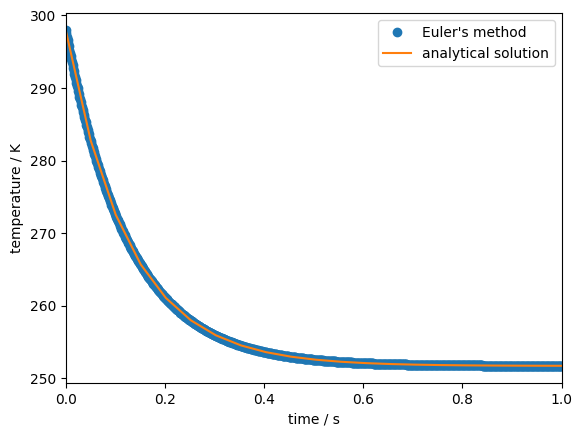

In [4]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.01*tau

Told = T0
told = 0

tmax = 1
nsteps = int(tmax/dt)
T_list = [Told]
t_list = [told]
for step in range(nsteps):
  tnew = told + dt
  dTdt = dotN_in/Nl*(Tin-Told)
  dTdt += - dotN_out*DeltaH/(Nl*C)
  dTdt += - hS/(Nl*C)*(Told-TC)
  Tnew = Told + dTdt*dt
  T_list.append(Tnew)
  t_list.append(tnew)
#  print(tnew, Tnew)
  Told = Tnew
  told = tnew

plt.plot(t_list, T_list, ls='None', marker='o', label="Euler's method")


# Analytical solution
t_list = np.linspace(0.0, 5, 100)
T_list = [T_inf + (T0-T_inf)*np.exp(-t/tau) for t in t_list]
plt.plot(t_list, T_list, label='analytical solution')


plt.legend()
plt.xlabel('time / s')
plt.ylabel('temperature / K')
plt.xlim(0, tmax)
plt.show()

The nice thing about having a numerical solution is that we can solve more complicated problems with out much more difficulty.  So far in this lecture, we have assume that the inlet molar flow rate of refrigerant is the same as the outlet flow.  Let's look at the case where $\dot{N}_{\rm out}=0.9\dot{N}_{\rm in}$, so that there is more liquid refrigerant entering the vessel that vapor refrigerant is withdrawn from the vessel.

We first modifify our code to include the mole balance.  In this case, we have
- $N_l(t)$: `Nlold`
- $N_l(t+\Delta t)$: `Nlnew`
- $\frac{dN_l(t)}{dt}$: `dNldt`

We compare this new problem to the analytical solution of the problem where the inflow and outflow are the same.

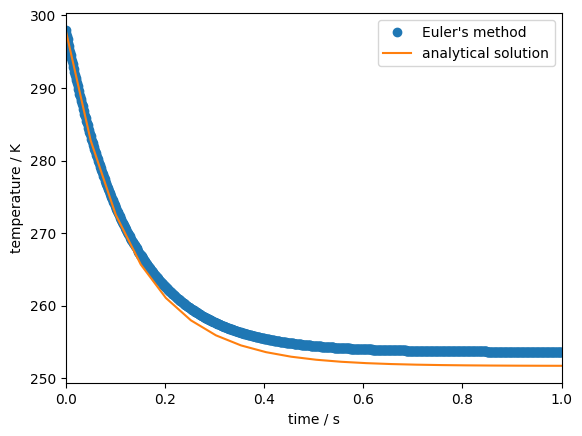

In [5]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.01*tau

Nlold = Nl_0
Told = T0
told = 0


tmax = 1
nsteps = int(tmax/dt)
T_list = [Told]
t_list = [told]
for step in range(nsteps):
  tnew = told + dt
  dotN_in = dotN*1.0
  dotN_out = dotN*0.9
  dNldt = dotN_in - dotN_out
  Nlnew = Nlold + dNldt * dt
  dTdt = dotN_in/Nl*(Tin-Told)
  dTdt += - dotN_out*DeltaH/(Nl*C)
  dTdt += - hS/(Nl*C)*(Told-TC)
  Tnew = Told + dTdt*dt
  T_list.append(Tnew)
  t_list.append(tnew)
#  print(tnew, Tnew)
  Told = Tnew
  told = tnew

plt.plot(t_list, T_list, ls='None', marker='o', label="Euler's method")


# Analytical solution
t_list = np.linspace(0.0, 5, 100)
T_list = [T_inf + (T0-T_inf)*np.exp(-t/tau) for t in t_list]
plt.plot(t_list, T_list, label='analytical solution')


plt.legend()
plt.xlabel('time / s')
plt.ylabel('temperature / K')
plt.xlim(0, tmax)
plt.show()

### Vapor pressure of refrigerant: R134a

To estimate the vapor pressure of the refrigerant, we use the Clausius-Clapeyron equation (see [Wikipedia](https://en.wikipedia.org/wiki/Clausius%E2%80%93Clapeyron_relation) or [C])
̄\begin{align*}
\frac{dp}{dT}
= \frac{p \Delta H}{R T^2}
\end{align*}
This is a first order differential equation, which can be separated and integrated to give
̄\begin{align*}
\ln\frac{p}{p_{\rm ref}}
=
\frac{\Delta H}{R T_{\rm ref}}\left(
  1 - \frac{T_{\rm ref}}{T}
  \right)
\end{align*}



Text(0, 0.5, 'vapor pressure / kPa')

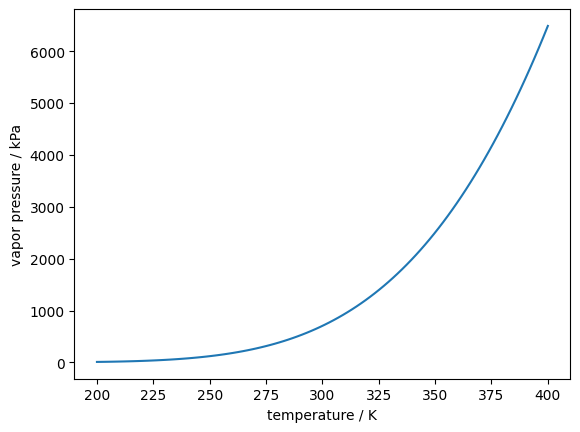

In [ ]:
T_list = np.linspace(200, 400, 100)
p_list = []
for T in T_list:
  ln_p = DeltaH/(R*Tref)*(1 - Tref/T)
  p = pref*np.exp(ln_p)
  p_list.append(p)
plt.plot(T_list, p_list)
plt.xlabel('temperature / K')
plt.ylabel('vapor pressure / kPa')

We can use the Clausius-Clapeyron equation to determine how the pressure of the vapor in the vessel varies with time.


We also make one modification of the problem.  Rather than specifying the molar flow rate of the gas leaving the vessel, we specify the volumetric flow rate $\dot{V}$.  In this case, the molar flow rate depends on the vapor molar density, which for an ideal gas is equal to:
\begin{align*}
\frac{N}{V} = \frac{p}{RT}
\end{align*}
The outlet molar flow rate of vapor is then:
\begin{align*}
\dot{N}_{\rm out}
&= \frac{p\dot{V}}{RT}
\end{align*}
For convenience, we assume that $\dot{N}_{\rm in}=\dot{N}_{\rm out}$, although we do not need to do this.



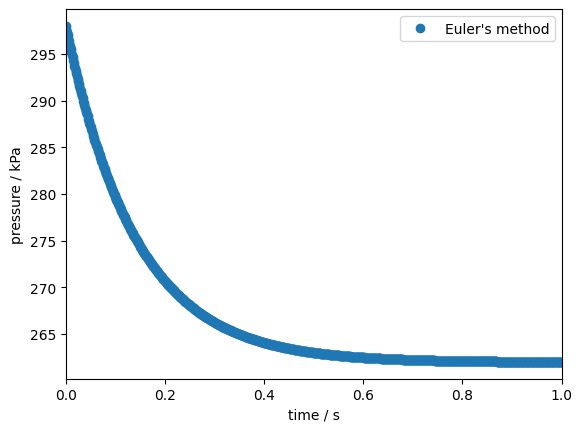

In [8]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.01*tau

Nlold = Nl_0
Told = T0
told = 0
ln_p = DeltaH/(R*Tref)*(1 - Tref/Told)
pold = pref*np.exp(ln_p)


dotN_in

tmax = 1
nsteps = int(tmax/dt)
T_list = [Told]
t_list = [told]
p_list = [pold]
dotV = 1
for step in range(nsteps):
  tnew = told + dt
  dotN_in = dotV * pold/(R*Told)
  dotN_out = dotV * pold/(R*Told)
  dNldt = dotN_in - dotN_out
  Nlnew = Nlold + dNldt * dt
  dTdt = dotN_in/Nl*(Tin-Told)
  dTdt += - dotN_out*DeltaH/(Nl*C)
  dTdt += - hS/(Nl*C)*(Told-TC)
  Tnew = Told + dTdt*dt
  ln_p = DeltaH/(R*Tref)*(1 - Tref/Tnew)
  pnew = pref*np.exp(ln_p)
  p_list.append(pnew)
  T_list.append(Tnew)
  t_list.append(tnew)
#  print(tnew, Tnew)
  Told = Tnew
  told = tnew

plt.plot(t_list, T_list, ls='None', marker='o', label="Euler's method")

#plt.plot(t_list, p_list, ls='None', marker='o', label="Euler's method")

plt.legend()
plt.xlabel('time / s')
plt.ylabel('pressure / kPa')
plt.xlim(0, tmax)
#plt.ylim(100, 600)
#plt.yscale('log')
plt.show()